In [84]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from surprise import accuracy
from surprise import SVD
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import PredefinedKFold, GridSearchCV, train_test_split, cross_validate

In [90]:
'''
http://files.grouplens.org/datasets/movielens/ml-100k-README.txt
'''

# Attributes in the data file are tab separated (\t).
# User = user_id
# Item = item_id
# Rating = rating
# Timestamp = timestamp
reader = Reader(line_format="user item rating timestamp", sep="\t", rating_scale=(1,5))

train_set = Dataset.load_from_file('./ml-100k/u1.base', reader=reader)

In [91]:
# Baseline SVD model
algorithm = SVD()

# Run 10-fold cross-validation and print results
baseline_results = cross_validate(algorithm, train_set, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9450  0.9428  0.9452  0.9492  0.9512  0.9467  0.0031  
MAE (testset)     0.7467  0.7422  0.7448  0.7492  0.7530  0.7472  0.0037  
Fit time          4.63    4.84    4.45    4.85    4.77    4.71    0.15    
Test time         0.19    0.18    0.19    0.22    0.18    0.19    0.02    


As there are many hyperparameters, the hyperparamters search can take a very long time. Therefore, we will tune smaller groups of hyperparameters one after another in order to get results in reasonable time. The final set of hyperparameters may not be the best, but they still show slight improvement over the baseline model.

##### Tune the number of epochs and regularisation constant

In [21]:
param_grid = {'n_epochs': [40, 80],
              'reg_all': [0.1, 0.15, 0.2, 0.25, 0.5]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=5)

gs.fit(train_set)

In [22]:
gs.best_params

{'rmse': {'n_epochs': 80, 'reg_all': 0.1},
 'mae': {'n_epochs': 80, 'reg_all': 0.1}}

In [23]:
gs.best_score

{'rmse': 0.9202596364472443, 'mae': 0.727769481687971}

In [24]:
tuning_epoch_and_reg_results = gs.cv_results
tuning_epoch_and_reg_df = pd.DataFrame.from_dict(tuning_epoch_and_reg_results)

In [31]:
tuning_epoch_and_reg_df.to_csv("tuning_epoch_and_reg.csv", index=False)

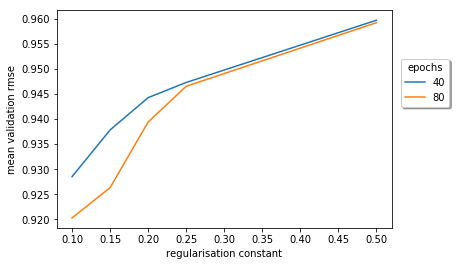

In [57]:
fig = plt.figure()
ax = plt.axes()
plt.xlabel("regularisation constant")
plt.ylabel("mean validation rmse")

x1 = tuning_epoch_and_reg_df[tuning_epoch_and_reg_df["param_n_epochs"] == 40]["param_reg_all"]
y1 = tuning_epoch_and_reg_df[tuning_epoch_and_reg_df["param_n_epochs"] == 40]["mean_test_rmse"]
ax.plot(x1, y1)

x2 = tuning_epoch_and_reg_df[tuning_epoch_and_reg_df["param_n_epochs"] == 80]["param_reg_all"]
y2 = tuning_epoch_and_reg_df[tuning_epoch_and_reg_df["param_n_epochs"] == 80]["mean_test_rmse"]
ax.plot(x2, y2)

chartBox = ax.get_position()
ax.set_position([chartBox.x0, chartBox.y0, chartBox.width, chartBox.height])
ax.legend(["40", "80"], title="epochs", loc='upper center', bbox_to_anchor=(1.1, 0.8), shadow=True, ncol=1)
# plt.legend()
plt.show()

Training the model with higher number of epochs can result in a better performance. For the chosen number of epochs, the regularisation constant should reamin small.

##### Tune the number of factors

In [17]:
param_grid = {'n_epochs': [80],
              'reg_all': [0.1],
              'n_factors': [120, 127, 135, 142, 150],
             }
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=5)

gs.fit(train_set)

In [18]:
gs.best_params

{'rmse': {'n_epochs': 80, 'reg_all': 0.1, 'n_factors': 135},
 'mae': {'n_epochs': 80, 'reg_all': 0.1, 'n_factors': 135}}

In [19]:
gs.best_score

{'rmse': 0.9198452031005063, 'mae': 0.7269879436415592}

In [20]:
tuning_n_factors_results = gs.cv_results

In [32]:
tuning_n_factors_df = pd.DataFrame.from_dict(tuning_n_factors_results)

In [33]:
tuning_n_factors_df.to_csv("tuning_n_factors.csv", index=False)

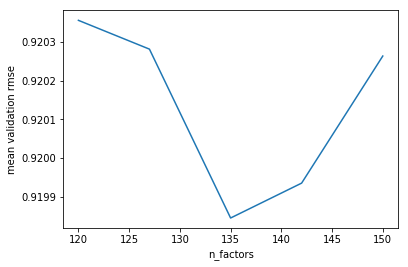

In [59]:
fig = plt.figure()
ax = plt.axes()
plt.xlabel("n_factors")
plt.ylabel("mean validation rmse")

x1 = tuning_n_factors_df["param_n_factors"]
y1 = tuning_n_factors_df["mean_test_rmse"]
ax.plot(x1, y1)

plt.show()

The model with 135 factors seem to have the lowest RMSE. However, the performance gain is not at all significant.

##### Tune the learning rate

In [62]:
param_grid = {'n_epochs': [80],
              'reg_all': [0.1],
              'n_factors': [135],
              'lr_all': [0.001, 0.0025, 0.005, 0.01, 0.05]
             }
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=5)

gs.fit(train_set)

In [64]:
gs.best_params

{'rmse': {'n_epochs': 80, 'reg_all': 0.1, 'n_factors': 135, 'lr_all': 0.005},
 'mae': {'n_epochs': 80, 'reg_all': 0.1, 'n_factors': 135, 'lr_all': 0.01}}

In [65]:
gs.best_score

{'rmse': 0.9201632948447933, 'mae': 0.7275779979884474}

In [66]:
tuning_lr_results = gs.cv_results

In [67]:
tuning_lr_results_df = pd.DataFrame.from_dict(tuning_lr_results)

In [68]:
tuning_lr_results_df.to_csv("tuning_lr_results.csv", index=False)

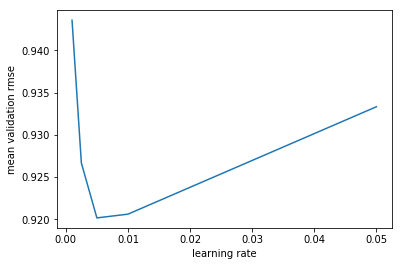

In [69]:
fig = plt.figure()
ax = plt.axes()
plt.xlabel("learning rate")
plt.ylabel("mean validation rmse")

x1 = tuning_lr_results_df["param_lr_all"]
y1 = tuning_lr_results_df["mean_test_rmse"]
ax.plot(x1, y1)

plt.show()

The learning rate of 0.005 provides the best performance.

##### Compare the baseline and tuned models on the test set

In [92]:
# Load test set
folds_files = [("./ml-100k/u1.base", "./ml-100k/u1.test")]
data = Dataset.load_from_folds(folds_files, reader=reader)
pkf = PredefinedKFold()

test_set = None
for _, s in pkf.split(data):
    test_set = s

In [93]:
# Baseline model
accuracy.rmse(algorithm.test(test_set))

RMSE: 0.9615


0.9615382766869889

In [99]:
# Tuned model
tuned_model = gs.best_estimator["rmse"]
tuned_model.fit(train_set.build_full_trainset())

In [100]:
accuracy.rmse(tuned_model.test(test_set))

RMSE: 0.9231


0.9231120676390854

The tuned model performs much better than the baseline model on the test set